In [32]:
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd
import numpy as np
# from prophet import Prophet
# from prophet.diagnostics import cross_validation, performance_metrics
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import holidays
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader


In [33]:
merged_df = pd.read_pickle('df_full.pkl')
merged_df = merged_df.reset_index()


In [34]:
merged_df[merged_df['Date'] == pd.Timestamp('2023-09-10')]


,Date,Day,Rooms Sold,Arrival Rooms,Compliment Rooms,House Use,Individual Confirm,Occupancy %,Room Revenue,ARR,Departure Rooms,OOO Rooms,Pax,Total Room Inventory
739,2023-09-10,Sunday,28.0,1.0,0.0,3.0,31.0,22.95,4698585.0,167806.61,90.0,8.0,33.0,122.0


In [35]:
print(merged_df.columns.tolist())

['Date', 'Day', 'Rooms Sold', 'Arrival Rooms', 'Compliment Rooms', 'House Use', 'Individual Confirm', 'Occupancy %', 'Room Revenue', 'ARR', 'Departure Rooms', 'OOO Rooms', 'Pax', 'Total Room Inventory']


In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'Date' is datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Remove outliers using IQR
Q1 = merged_df['Room Revenue'].quantile(0.25)
Q3 = merged_df['Room Revenue'].quantile(0.75)
IQR = Q3 - Q1
filtered_df=merged_df
# Keep only non-outlier data
filtered_df = merged_df[
    (merged_df['Room Revenue'] >= Q1 - 1.5 * IQR) &
    (merged_df['Room Revenue'] <= Q3 + 1.5 * IQR)
]

# Scatter plot with thin dots after outlier removal
# plt.figure(figsize=(10, 6))
# plt.scatter(filtered_df['Date'], filtered_df['Room Revenue'], color='blue', s=10)

# plt.title('Date vs Room Revenue (Outliers Removed)')
# plt.xlabel('Date')
# plt.ylabel('Room Revenue')
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


In [37]:
import pandas as pd

# Ensure 'Date' is datetime and sorted
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df = merged_df.sort_values('Date')

# Create a complete date range
full_range = pd.date_range(merged_df['Date'].min(), merged_df['Date'].max())

# Find missing dates
missing_dates = full_range.difference(merged_df['Date'])

if len(missing_dates) == 0:
    print("✅ No missing dates.")
else:
    print(f"⚠️ Total missing dates: {len(missing_dates)}")
    print("Showing first 20 missing dates (to avoid overload):")
    print(missing_dates)


⚠️ Total missing dates: 29
Showing first 20 missing dates (to avoid overload):
DatetimeIndex(['2024-11-17', '2024-11-18', '2024-11-19', '2024-11-20',
               '2024-11-21', '2024-11-22', '2024-11-23', '2024-11-24',
               '2024-11-25', '2024-11-26', '2024-11-27', '2024-11-28',
               '2024-11-29', '2024-11-30', '2024-12-01', '2024-12-02',
               '2024-12-03', '2024-12-04', '2024-12-05', '2024-12-06',
               '2024-12-07', '2024-12-08', '2024-12-09', '2024-12-10',
               '2024-12-11', '2024-12-12', '2024-12-13', '2024-12-14',
               '2024-12-15'],
              dtype='datetime64[ns]', freq=None)


In [38]:
merged_df[merged_df['Date'] == pd.Timestamp('2023-09-10')]


,Date,Day,Rooms Sold,Arrival Rooms,Compliment Rooms,House Use,Individual Confirm,Occupancy %,Room Revenue,ARR,Departure Rooms,OOO Rooms,Pax,Total Room Inventory
739,2023-09-10,Sunday,28.0,1.0,0.0,3.0,31.0,22.95,4698585.0,167806.61,90.0,8.0,33.0,122.0


ERROR - (NP.df_utils.get_normalization_params) - Normalization True not defined.
ERROR - (NP.df_utils.get_normalization_params) - Normalization True not defined.
Finding best initial lr: 100%|██████████| 225/225 [00:01<00:00, 165.94it/s]
WARNING - (py.warnings._showwarnmsg) - c:\Users\jnami\.conda\envs\nammu\lib\site-packages\lightning_fabric\utilities\cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `tor

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.91it/s]
✅ Test RMSE (aligned): 169,301.69


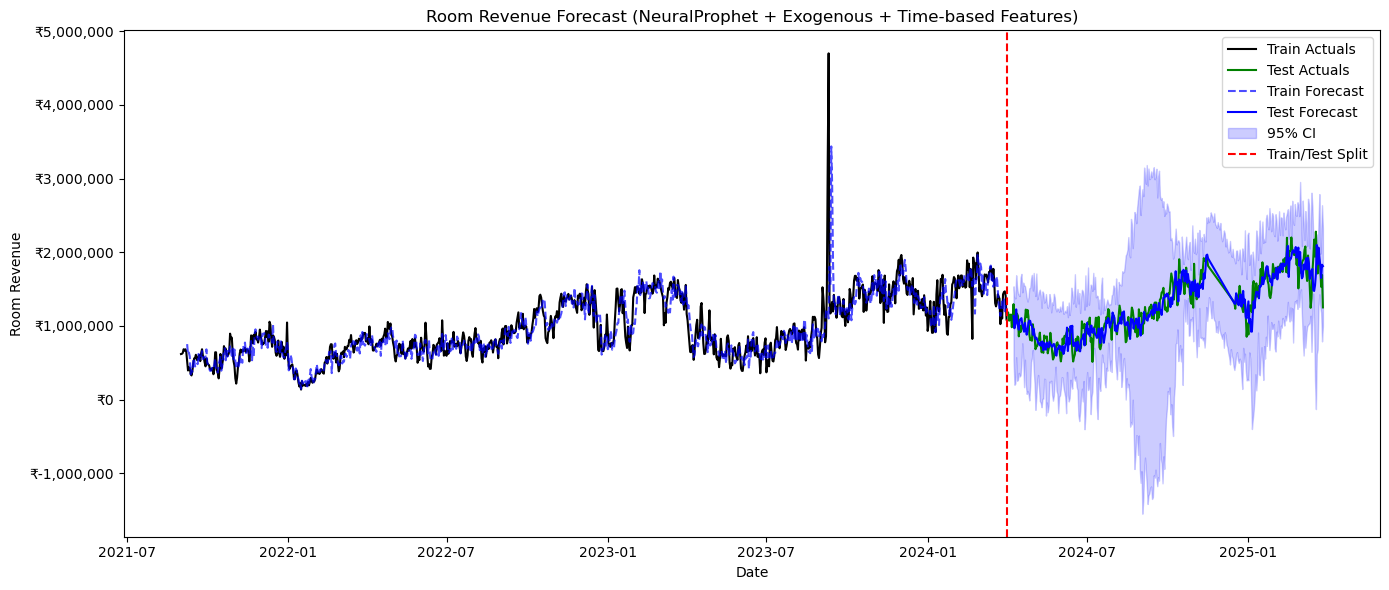

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from neuralprophet import NeuralProphet, set_log_level
from sklearn.metrics import mean_squared_error
import holidays

set_log_level("ERROR")

# =====================================================
# STEP 1: Data Preparation Function (Robust)
# =====================================================
def prepare_prophet_data(df, target_col='Room Revenue', exogenous_cols=None):
    # --- Step 1: Normalize column names ---
    # df.columns = df.columns.str.strip()
    # df.columns = df.columns.str.title()

    # --- Step 2: Handle separate Date and Day columns ---
    # if 'Date' in df.columns and 'Day' in df.columns:
    #     df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # elif 'date' in df.columns:
    #     df['Date'] = pd.to_datetime(df['date'], errors='coerce')
    # else:
    #     raise KeyError("No column named 'Date' or 'date' found in dataset.")
    
    # df = df.sort_values('Date').drop_duplicates(subset=['Date'])
    df.set_index('Date', inplace=True)

    # --- Step 3: Prophet-format dataset ---
    prophet_df = pd.DataFrame({'ds': df.index, 'y': df[target_col]})
    
    # --- Step 4: Add exogenous regressors ---
    # if exogenous_cols:
    #     for col in exogenous_cols:
    #         col_clean = col.strip()
    #         if col_clean in df.columns:
    prophet_df['Arrival Rooms'] = df['Arrival Rooms']
    
    # --- Step 5: Add time-based features ---
    # prophet_df['is_weekend'] = prophet_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)
    # prophet_df['month'] = prophet_df['ds'].dt.month
    # prophet_df['quarter'] = prophet_df['ds'].dt.quarter

    # --- Step 6: Add Indian holidays ---
    # in_holidays = holidays.IN()
    # prophet_df['is_holiday'] = prophet_df['ds'].dt.date.apply(lambda x: int(x in in_holidays))
    
    # --- Step 7: Rolling stats on target ---
    # for window in [7, 14]:
    #     prophet_df[f'rolling_mean_{window}d'] = df[target_col].rolling(window).mean()
    #     prophet_df[f'rolling_std_{window}d'] = df[target_col].rolling(window).std()

    # --- Step 8: Fill missing values ---
    
    prophet_df.fillna(method='bfill', inplace=True)
    prophet_df.fillna(method='ffill', inplace=True)

    # --- Step 9: Drop duplicates ---
    prophet_df = prophet_df.drop_duplicates(subset=['ds'])

    return prophet_df


# =====================================================
# STEP 2: Define exogenous columns
# =====================================================
exog_cols = [
    'Arrival Rooms', 'Compliment Rooms', 'House Use',
    'Individual Confirm', 'Arr', 'Departure Rooms'
]

# =====================================================
# STEP 3: Prepare your data
# =====================================================
prophet_df = prepare_prophet_data(merged_df, target_col='Room Revenue', exogenous_cols=exog_cols)

# Add all derived columns to model as regressors
derived_features = [
    'is_weekend', 'month', 'quarter', 'is_holiday',
    'rolling_mean_7d', 'rolling_std_7d',
    'rolling_mean_14d', 'rolling_std_14d'
]

# =====================================================
# STEP 4: Chronological Split
# =====================================================
train_df = prophet_df[prophet_df['ds'] < '2024-04-01']
test_df  = prophet_df[prophet_df['ds'] >= '2024-04-01']

# =====================================================
# STEP 5: Define NeuralProphet Model
# =====================================================
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_lags=7,
    n_forecasts=1,
    quantiles=[0.025, 0.5, 0.975]
)
# Register all regressors (manual + derived)
# for col in exog_cols + derived_features:
#     if col in prophet_df.columns:
#         m.add_future_regressor(name=col, normalize=True)
m.add_future_regressor(name='Arrival Rooms', normalize=True)
# =====================================================
# STEP 6: Train
# =====================================================
metrics = m.fit(train_df, freq='D', validation_df=test_df)

# =====================================================
# STEP 7: Forecast
# =====================================================
forecast_train = m.predict(train_df)
forecast_test = m.predict(test_df)

# =====================================================
# STEP 8: Evaluate (Fixed Alignment)
# =====================================================
# Align forecast and actual values by date
forecast_test_aligned = forecast_test[['ds', 'yhat1']].merge(
    test_df[['ds', 'y']], on='ds', how='inner'
)
forecast_test_aligned.dropna(subset=['y', 'yhat1'], inplace=True)

mse = mean_squared_error(forecast_test_aligned['y'], forecast_test_aligned['yhat1'])
rmse=np.sqrt(mse)
print(f"✅ Test RMSE (aligned): {rmse:,.2f}")

# =====================================================
# STEP 9: Plot Forecast (Aligned)
# =====================================================
plt.figure(figsize=(14,6))

plt.plot(train_df['ds'], train_df['y'], 'k-', label="Train Actuals")
plt.plot(test_df['ds'], test_df['y'], 'g-', label="Test Actuals")

plt.plot(forecast_train['ds'], forecast_train['yhat1'], 'b--', alpha=0.7, label="Train Forecast")
plt.plot(forecast_test_aligned['ds'], forecast_test_aligned['yhat1'], 'b-', label="Test Forecast")

plt.fill_between(
    forecast_test['ds'],
    forecast_test['yhat1 2.5%'],
    forecast_test['yhat1 97.5%'],
    color='blue', alpha=0.2, label="95% CI"
)

plt.axvline(pd.to_datetime("2024-04-01"), color="red", linestyle="--", label="Train/Test Split")

plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, p: f"₹{x:,.0f}")
)

plt.title("Room Revenue Forecast (NeuralProphet + Exogenous + Time-based Features)")
plt.xlabel("Date")
plt.ylabel("Room Revenue")
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
# Check data types
print(prophet_df.dtypes)

# Show a few recent rows
print(prophet_df.tail(10))

# Check basic stats
print(prophet_df['y'].describe())

# Check if there are any NaN or zero values
print(prophet_df['y'].isna().sum(), "NaN values in y")
print((prophet_df['y'] == 0).sum(), "zero values in y")



ds               datetime64[ns]
y                       float64
Arrival Rooms           float64
dtype: object
                   ds           y  Arrival Rooms
Date                                            
2025-03-18 2025-03-18  1940710.60           47.0
2025-03-19 2025-03-19  2279133.55           48.0
2025-03-20 2025-03-20  1906720.13           56.0
2025-03-21 2025-03-21  1710974.73           41.0
2025-03-22 2025-03-22  1965306.33           54.0
2025-03-23 2025-03-23  1851855.06           44.0
2025-03-24 2025-03-24  1811691.65           44.0
2025-03-25 2025-03-25  1530109.89           24.0
2025-03-26 2025-03-26  1691671.37           44.0
2025-03-27 2025-03-27  1251042.51           37.0
count    1.275000e+03
mean     1.046599e+06
std      4.381735e+05
min      1.360455e+05
25%      7.168817e+05
50%      9.625822e+05
75%      1.386099e+06
max      4.698585e+06
Name: y, dtype: float64
0 NaN values in y
0 zero values in y


In [41]:
gds=prophet_df[(prophet_df['ds'] < '2023-10-30') & (prophet_df['ds'] >= '2023-07-01')]
gds.to_csv('gds.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'gds.csv'